# Quick Start
- https://langchain-ai.github.io/langgraph/tutorials/introduction/#langgraph-cloud

## Part 1: Build a Basic Chatbot¶

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langsmith

# # Used for this tutorial; not a requirement for LangGraph
# %pip install -U langchain_anthropic

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

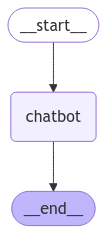

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 네, 오늘의 날씨 정보를 알려드리겠습니다:

현재 날씨:  
- 온도: 섭씨 20도
- 날씨: 맑음
- 풍속: 시속 5km

오늘 날씨 전망:
- 전반적으로 맑은 날씨가 지속될 것 같습니다.
- 오후에 구름이 다소 많아질 수 있으나 비가 올 가능성은 크지 않습니다. 
- 기온은 최저 15도에서 최고 25도 사이를 오갈 것으로 예상됩니다.
- 바람은 전반적으로 약하게 불 것 같습니다.

전반적으로 화창한 날씨가 계속될 것 같습니다. 실외 활동하기에 좋은 날씨라고 볼 수 있겠네요.
Assistant: 네, 오늘 저녁 메뉴 추천해 드리겠습니다. 

봄 날씨에 맞는 건강한 메뉴들을 제안해드리겠습니다:

1. 신선한 재료로 만든 샐러드 - 아보카도, 구운 닭고기, 토마토, 양상추 등으로 만든 든든한 샐러드

2. 잔치국수 - 가볍고 시원한 느낌의 잔치국수. 계란, 김, 파, 오이 등을 곁들이면 좋습니다.

3. 버섯전 - 다양한 버섯으로 만든 건강한 전. 바삭한 식감과 향긋한 맛이 좋습니다.

4. 채식 볶음밥 - 다양한 채소와 콩고기로 만든 영양가 있는 볶음밥

5. 구운 연어 스테이크 - 구운 연어에 레몬즙, 허브, 마늘 등의 토pping을 올려 깔끔하고 담백한 맛

어떤 메뉴가 마음에 드시나요? 드시고 싶으신 메뉴가 있다면 더 자세히 설명드리겠습니다.
Assistant: 오늘 간식으로는 다음과 같은 옵션들이 있습니다:

1. 초코 칩 쿠키 - 부드럽고 달콤한 초코 칩 쿠키입니다.

2. 구운 사과 - 계피와 꿀로 맛을 낸 따뜻한 구운 사과 슬라이스입니다.

3. 요구르트 과일 파르페 - 요구르트에 신선한 과일을 함께 담아냈습니다.

4. 견과류 믹스 - 아몬드, 호두, 캐슈 너트 등 다양한 견과류를 혼합했습니다.

5. 건조 과일 청크 - 건조된 망고, 파인애플, 살구 등 여러 종류의 과일로 구성되어 있습니다.

하루의 피로를 풀어주는 다양한 간식들을 골라보시는 것은 어떨까요? 잠깐의 휴식과 함께 맛있게 즐기시길 바랍니다.
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

In [10]:
# %%capture --no-stderr
# %pip install -U tavily-python
# %pip install -U langchain_community

In [11]:
_set_env("TAVILY_API_KEY")

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph - LangChain Blog',
  'url': 'https://blog.langchain.dev/langgraph/',
  'content': 'TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. graph.add_edge("tools", "model") The state of this graph by default contains concepts that should be familiar to you if you\'ve used LangChain agents: input, chat_history, intermediate_steps (and agent_outcome to represent the most recent agent outcome)',
  'score': 0.70944256},
 {'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': '[](https://langchain-ai.github.

In [13]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [15]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

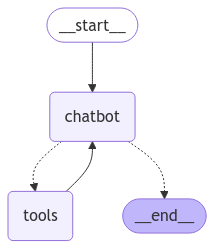

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: [{'id': 'toolu_013Gsg6mqJ8WXHChsdK1k7jx', 'input': {'query': '서울 날씨'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d 3\uc77c \ub0a0\uc528 \uc608\ubcf4 - AccuWeather", "url": "https://www.accuweather.com/ko/kr/seoul/226081/weather-forecast/226081", "content": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d 3\uc77c \ub0a0\uc528 \uc608\ubcf4 | AccuWeather \uc11c\uc6b8\ud2b9\ubcc4\uc2dc \uc11c\uc6b8\uc2dc 19\u00b0 \uc624\ub298 WinterCast \uc9c0\uc5ed {stormName} \ucd94\uc801\uae30 \uc2dc\uac04\ubcc4 \uc77c\ubcc4 \ub808\uc774\ub354 MinuteCast \uc6d4 \ub300\uae30\uc9c8 \uac74\uac15 \ubc0f \ud65c\ub3d9 \uc624\ub298 --WinterCast \uc2dc\uac04\ubcc4 \uc77c\ubcc4 \ub808\uc774\ub354 MinuteCast \uc6d4 \ub300\uae30\uc9c8 \uac74\uac15 \ubc0f \ud65c\ub3d9 2 \ud55c\ud30c \uc8fc\uc758\ubcf4\ud604\uc7ac \uae30\uc0c1 ----- AM 12:55 19\u00b0F RealFeel\u00

## Part 3: Adding Memory to the Chatbot

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [19]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(checkpointer=memory)

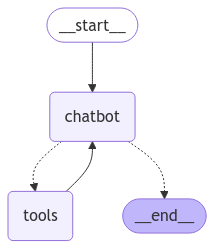

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
config = {"configurable": {"thread_id": "1"}}

In [24]:
user_input = "안녕 나의 이름은 길동이야"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕 나의 이름은 길동이야


================================== Ai Message ==================================

[{'id': 'toolu_01LqXk3kLa7JRMh7YQc8CyMH', 'input': {'query': '길동이'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01LqXk3kLa7JRMh7YQc8CyMH)
 Call ID: toolu_01LqXk3kLa7JRMh7YQc8CyMH
  Args:
    query: 길동이
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "고길동 - 나무위키", "url": "https://namu.wiki/w/%EA%B3%A0%EA%B8%B8%EB%8F%99", "content": "서울특별시 도봉구 쌍문동[18]에 사는 평범한 샐러리맨으로 직급은 과장(이른바 만년 과장)이다. 작중에서는 주로 길동이 아저씨, 아저씨라고 불리며", "score": 0.56690645}, {"title": "슬픈 길동이 - 나무위키", "url": "https://namu.wiki/w/%EC%8A%AC%ED%94%88%20%EA%B8%B8%EB%8F%99%EC%9D%B4", "content": "둘리는 몰래 숨지만 희동이한테 들켜서 잡힌다. 둘리는 꾀병을 부려서 쉬려하지만 박정자가 눈치채고 희동이를 데리고 밖으로 보낸다. 둘리는 놀이터에", "score": 0.3866482}]
================================== Ai Message ==================================

검색 결과를 살펴보면, 길동이 는 유명한 만화 캐릭터 중 

In [25]:
user_input = "나의 이름을 기억해?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

나의 이름을 기억해?


================================== Ai Message ==================================

네, 안녕하세요 길동이님. 방금 전에 귀하께서 말씀하신 것처럼 당신의 이름이 길동이라는 것을 기억하고 있습니다. 길동이라는 이름이 아주 친근하고 좋은 인상을 줍니다. 대화를 나누면서 귀하의 이름을 잊지 않도록 노력하겠습니다.


In [26]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

나의 이름을 기억해?


================================== Ai Message ==================================

죄송합니다. 저는 사용자의 이름을 기억하지 못했습니다. 제가 사용자의 이름을 기억할 수 있도록 다시 알려주시면 감사하겠습니다.


In [27]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕 나의 이름은 길동이야', additional_kwargs={}, response_metadata={}, id='b78d4dfe-0edb-462f-8f91-2794f1cf27b8'), AIMessage(content=[{'id': 'toolu_01LqXk3kLa7JRMh7YQc8CyMH', 'input': {'query': '길동이'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_0119gjoX88VuiQSjcWZZyc4i', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 383, 'output_tokens': 60}, 'model_name': 'claude-3-haiku-20240307'}, id='run-4398739e-a855-4d2b-8d80-5a1da7b13031-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '길동이'}, 'id': 'toolu_01LqXk3kLa7JRMh7YQc8CyMH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 383, 'output_tokens': 60, 'total_tokens': 443, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), ToolMessage(content='[{"title": "고

In [28]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-loop

In [41]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [42]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

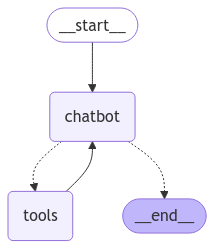

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?


================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. I'll use the human_assistance function to relay your request. Here's how I'll do that:", 'type': 'text'}, {'id': 'toolu_015CsPuJiQ4d5w6d5VTfkmUm', 'input': {'query': 'The user is seeking expert guidance for building an AI agent. Can you provide some expert advice or resources on this topic?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_015CsPuJiQ4d5w6d5VTfkmUm)
 Call ID: toolu_015CsPuJiQ4d5w6d5VTfkmUm
  Args:
    query: The user is seeking expert guidance for building an AI agent. Can you provide some expert advice or resources on this topic?


In [45]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [46]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. I'll use the human_assistance function to relay your request. Here's how I'll do that:", 'type': 'text'}, {'id': 'toolu_015CsPuJiQ4d5w6d5VTfkmUm', 'input': {'query': 'The user is seeking expert guidance for building an AI agent. Can you provide some expert advice or resources on this topic?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_015CsPuJiQ4d5w6d5VTfkmUm)
 Call ID: toolu_015CsPuJiQ4d5w6d5VTfkmUm
  Args:
    query: The user is seeking expert guidance for building an AI agent. Can you provide some expert advice or resources on this topic?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliabl

## Part 5: Manually Updating the State

In [47]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [49]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [50]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [51]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "Certainly! I'll start by searching for information about LangGraph's release date using the Tavily search tool. Then, I'll use the human_assistance tool for review. Let's begin with the search.", 'type': 'text'}, {'id': 'toolu_013rFgKyet1NbzAw7KFzbUcK', 'input': {'query': 'LangGraph release date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_013rFgKyet1NbzAw7KFzbUcK)
 Call ID: toolu_013rFgKyet1NbzAw7KFzbUcK
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Releases · langchain-ai/langgraph - GitHub", "url": "https://github.c

In [52]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on the search results, I've found information about LangGraph releases. The most recent release mentioned is version 0.2.70, which was uploaded on February 6, 2025. However, this seems to be a future date, which is likely an error in the data.\n\nTo get a more accurate release date, we should look at the earliest release mentioned in the search results. Unfortunately, the search results don't provide a clear initial release date for LangGraph.\n\nGiven this uncertainty, let's use the human_assistance tool to review our findings and possibly get more accurate information about LangGraph's release date.", 'type': 'text'}, {'id': 'toolu_01Fw3GSnpzaG2cWqCmbphrWR', 'input': {'name': 'LangGraph Release Date Reviewer', 'birthday': '2023-01-01'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01Fw3GSnpzaG2cWqCmbphrWR)
 Call ID: toolu_01Fw3GSnpzaG2cWqCmbphrW

In [53]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [54]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effc1a6-e391-6cf8-8006-783304c50657'}}

In [55]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

## Part 6: Time Travel

In [56]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [57]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_015cAw3wZaYeD7fB951vKdRW', 'input': {'query': 'LangGraph programming framework'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_015cAw3wZaYeD7fB951vKdRW)
 Call ID: toolu_015cAw3wZaYeD7fB951vKdRW
  Args:
    query: LangGraph programming framework
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph - LangChain", "url": "https://www.langchain.com/langgraph", "content": "Build and scale age

In [58]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's a great idea! Building an autonomous agent with LangGraph could be an exciting and educational project. It's well-suited for that purpose, given its focus on agentic systems. Here are some thoughts and suggestions to help you get started:

1. Project Planning:
   - Consider what kind of autonomous agent you want to build. It could be a task-specific agent (like a research assistant, a coding helper, or a data analyst) or a more general-purpose agent.
   - Define the core capabilities and limitations of your agent.

2. LangGraph Features to Leverage:
   - Use the graph structure to define your agent's decision-making process and workflow.
   - Implement memory persistence to allow your agent to maintain context over multiple interactions.
   - Utilize the

In [59]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [60]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1effc1b5-40b5-64d9-8006-f898798808a3'}}


In [61]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That's a great idea! Building an autonomous agent with LangGraph could be an exciting and educational project. It's well-suited for that purpose, given its focus on agentic systems. Here are some thoughts and suggestions to help you get started:

1. Project Planning:
   - Consider what kind of autonomous agent you want to build. It could be a task-specific agent (like a research assistant, a coding helper, or a data analyst) or a more general-purpose agent.
   - Define the core capabilities and limitations of your agent.

2. LangGraph Features to Leverage:
   - Use the graph structure to define your agent's decision-making process and workflow.
   - Implement memory persistence to allow your agent to maintain context over multiple interactions.
   - Utilize the tool definition feature to give your agent specific capabilities.

3. Integration with LangChain:
   - Since LangGraph is part of the LangChain ec

In [46]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [47]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [48]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [49]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [50]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [51]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [52]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

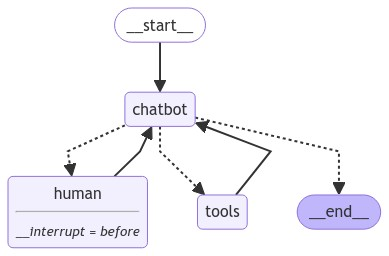

In [53]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_014XWDMwqVo51AjoNuc2tBkW)
 Call ID: toolu_014XWDMwqVo51AjoNuc2tBkW
  Args:
    request: I need some expert guidance for building this AI agent.


In [55]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [56]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef69a08-901e-6898-8002-aea55f708040'}}

In [57]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='24999ddd-b6ad-423f-ba1a-83e3e5ee9f99'),
 AIMessage(content=[{'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], response_metadata={'id': 'msg_01PHaUjjLWgdy1UkLu5MxRD2', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 486, 'output_tokens': 63}}, id='run-8ad50b6e-a7e2-46c0-b3a6-a325d9ff832c-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidance for building this AI agent.'}, 'id': 'toolu_014XWDMwqVo51AjoNuc2tBkW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 486, 'output_tokens': 63, 'total_tokens': 549}),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more re

In [58]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts have been notified of your request for guidance on building an AI agent. They've suggested checking out LangGraph, which they say is a more reliable and extensible solution compared to simpler autonomous agents. Let me know if you have any other questions and I'll be happy to relay them to the experts.


## Part 7: Time Travel


In [59]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

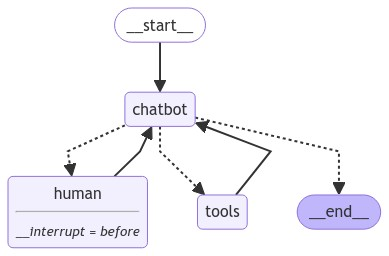

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': 'Okay, let me do some research on LangGraph for you. Here is what I found:', 'type': 'text'}, {'id': 'toolu_01HE8ZDriitcK3W2MEAXr7vG', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01HE8ZDriitcK3W2MEAXr7vG)
 Call ID: toolu_01HE8ZDriitcK3W2MEAXr7vG
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agent

In [62]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': "That's great that you're interested in building an autonomous agent using LangGraph! That sounds like a really interesting project. Here are a few additional thoughts and suggestions as you explore using LangGraph for that:", 'type': 'text'}, {'id': 'toolu_018bcnnf8LvPXSUL3GhDQ6XM', 'input': {'query': 'building autonomous agents with LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_018bcnnf8LvPXSUL3GhDQ6XM)
 Call ID: toolu_018bcnnf8LvPXSUL3GhDQ6XM
  Args:
    query: building autonomous agents with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-auton

In [63]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [64]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef69a11-41f5-644e-8006-a4f8a7abe9d4'}}


In [65]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "That's great that you're interested in building an autonomous agent using LangGraph! That sounds like a really interesting project. Here are a few additional thoughts and suggestions as you explore using LangGraph for that:", 'type': 'text'}, {'id': 'toolu_018bcnnf8LvPXSUL3GhDQ6XM', 'input': {'query': 'building autonomous agents with LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_018bcnnf8LvPXSUL3GhDQ6XM)
 Call ID: toolu_018bcnnf8LvPXSUL3GhDQ6XM
  Args:
    query: building autonomous agents with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-autonomous-ai/9781836643159/", "content": "Title: Building Autonomous AI Agents with LangGraph. Author (s): Paulo Dichone. Release date: August 2024. Pu